In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error



## Pre procesamiento


##### 1. Variables Objetivo y Características 
- **Variables objetivo (target)**: predecir el rendimiento por grado por materia,  usando cada una de las calificaciones (Cognitiva, Procedimental, Actitudinal, Axiologica) como variable objetivo.
- **Características (features)**: Las demás columnas se utilizarán como características para predecir la variable objetivo.

##### 2. Tipos de Variables: 
- **Variables categóricas**: Sede, Estudiante, Grado, Grupo, Periodo, Año, Asignatura.
- **Variables numéricas**: Intensidad Horaria, Cognitiva, Procedimental, Actitudinal, Axiologica.

### Agrupar por Grado y Asignatura

In [3]:
calificaciones_to_model_fusa = pd.read_csv("calificaciones_to_model_fusa.csv")
calificaciones_to_model_girardot = pd.read_csv("calificaciones_to_model_girardot.csv")


In [4]:
# Seleccionar solo las columnas numéricas
numerical_columns = ['Intensidad Horaria', 'Cognitiva', 'Procedimental', 'Actitudinal', 'Axiologica','Calificacion_Ponderada']

calificaciones_grouped_fusa = calificaciones_to_model_fusa.groupby(['Grado','Asignatura','Periodo','Año'])[numerical_columns].mean().reset_index()
calificaciones_grouped_girardot = calificaciones_to_model_girardot.groupby(['Grado', 'Asignatura','Periodo','Año'])[numerical_columns].mean().reset_index()


In [5]:
calificaciones_grouped_fusa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Grado                   756 non-null    int64  
 1   Asignatura              756 non-null    object 
 2   Periodo                 756 non-null    object 
 3   Año                     756 non-null    int64  
 4   Intensidad Horaria      756 non-null    float64
 5   Cognitiva               756 non-null    float64
 6   Procedimental           756 non-null    float64
 7   Actitudinal             756 non-null    float64
 8   Axiologica              756 non-null    float64
 9   Calificacion_Ponderada  756 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 59.2+ KB


In [6]:
calificaciones_grouped_girardot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Grado                   528 non-null    int64  
 1   Asignatura              528 non-null    object 
 2   Periodo                 528 non-null    object 
 3   Año                     528 non-null    int64  
 4   Intensidad Horaria      528 non-null    float64
 5   Cognitiva               528 non-null    float64
 6   Procedimental           528 non-null    float64
 7   Actitudinal             528 non-null    float64
 8   Axiologica              528 non-null    float64
 9   Calificacion_Ponderada  528 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 41.4+ KB


### Variables características (features) y objetivo (target)

In [7]:
X_fusa = calificaciones_grouped_fusa[['Grado', 'Asignatura', 'Intensidad Horaria','Periodo','Año']]
y_fusa = calificaciones_grouped_fusa[['Calificacion_Ponderada']]

In [8]:
X_girardot = calificaciones_grouped_girardot[['Grado', 'Asignatura', 'Intensidad Horaria','Periodo','Año']]
y_girardot = calificaciones_grouped_girardot[['Calificacion_Ponderada']]

## Modelado con Random Forest Regression

### - Funcion modelado Regresion

In [9]:
def train_evaluate_random_forest_r(X, y):
    # Definir el preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Intensidad Horaria']),
            ('cat', OneHotEncoder(), ['Grado', 'Asignatura', 'Periodo', 'Año'])
        ])
    
    # Crear el pipeline para el modelo Random Forest
    model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor())])
    
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo Random Forest
    model_rf.fit(X_train, y_train)
    
    # Evaluar el modelo
    score = model_rf.score(X_test, y_test)
    print(f'R^2 Score: {score:.2f}')
    
    # Obtener predicciones
    y_pred = model_rf.predict(X_test)
    # Obtener otras métricas si es necesario
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    return model_rf, score, y_test, y_pred

In [10]:

def train_evaluate_svr(X, y):
    
    # Definir el preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Intensidad Horaria']),
            ('cat', OneHotEncoder(), ['Grado', 'Asignatura','Periodo','Año'])
        ])
    
    # Crear el pipeline para el modelo SVM
    model_svr = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', SVR())])
    
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo SVM
    model_svr.fit(X_train, y_train)
    
    # Evaluar el modelo
    score = model_svr.score(X_test, y_test)
    
    # Obtener predicciones
    y_pred = model_svr.predict(X_test)
    
    return model_svr, score, y_test, y_pred

### - Funcion graficos

In [11]:
def plot_results(y_test, y_pred, title_prefix):
    # Convertir a numpy arrays si es necesario
    y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test
    y_pred = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else y_pred
    
    # Gráfico de Predicciones vs. Valores Reales
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3, edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(f'{title_prefix} - Predicciones vs. Valores Reales')
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.grid(True)
    plt.show()

    # Gráfico de Errores
    errors = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'{title_prefix} - Distribución de Errores de Predicción')
    plt.xlabel('Error')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

#### Entrenar y evaluar modelo RandomForestRegression para Fusagasugá

C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R^2 Score: 0.52
Mean Squared Error: 10.63
Mean Absolute Error: 2.37
Fusagasugá - RandomForestRegression R^2 Score: 0.52


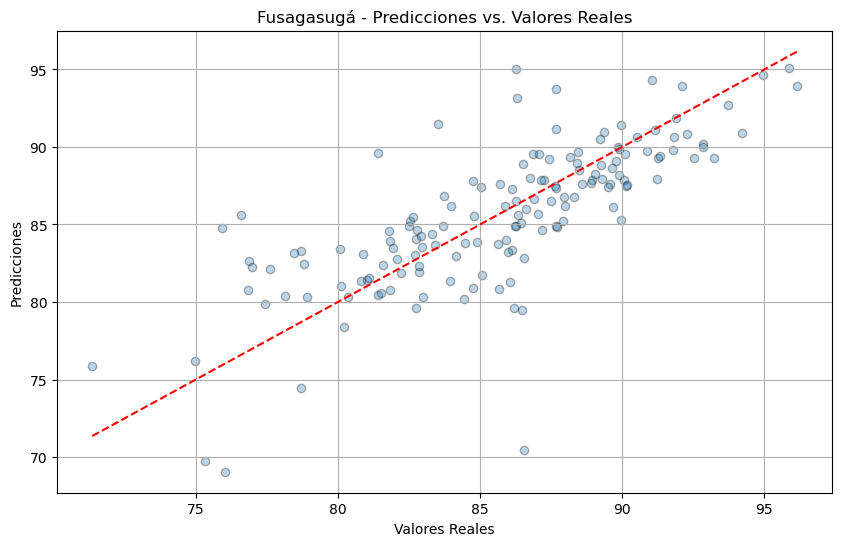

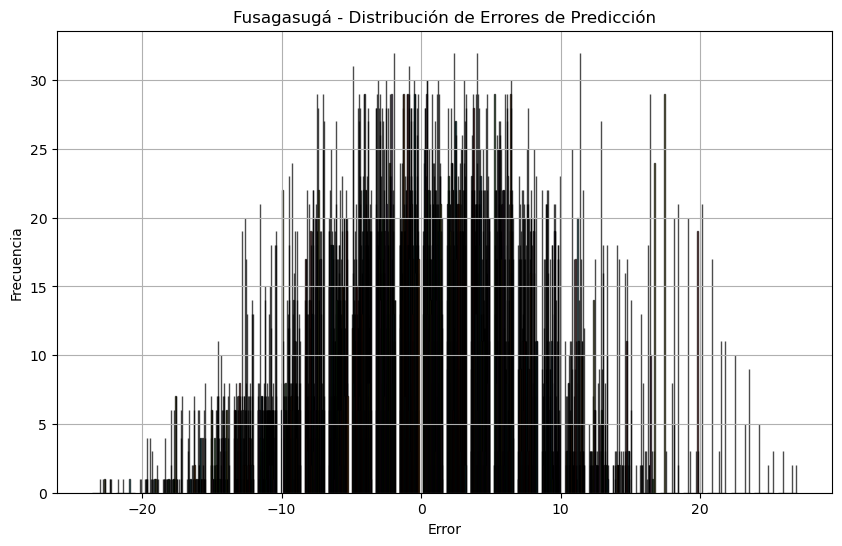

In [12]:
model_f, score_f, y_test_f, y_pred_f = train_evaluate_random_forest_r(X_fusa, y_fusa)
print(f'Fusagasugá - RandomForestRegression R^2 Score: {score_f:.2f}')
plot_results(y_test_f, y_pred_f, 'Fusagasugá')

#### Entrenar y evaluar modelo RandomForestRegression para Girardot

C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R^2 Score: 0.37
Mean Squared Error: 15.95
Mean Absolute Error: 2.90
Girardot - RandomForestRegression R^2 Score: 0.37


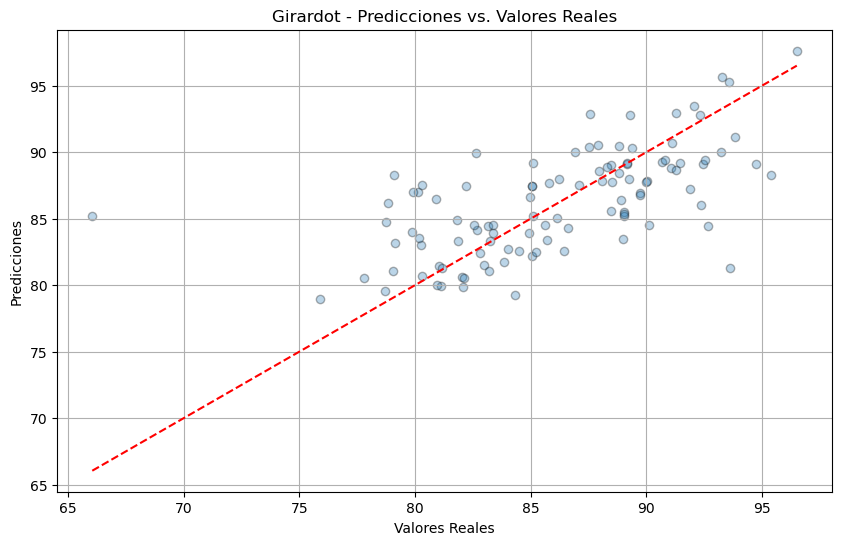

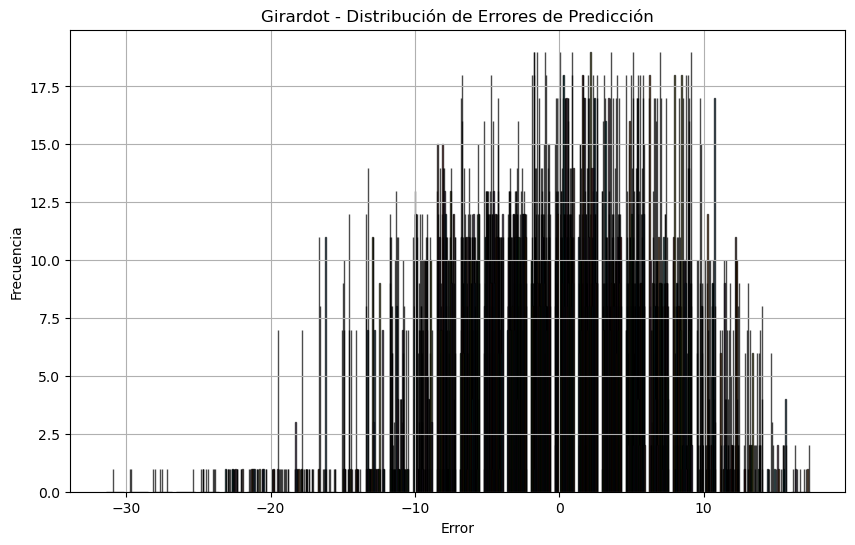

In [13]:
model_g, score_g, y_test_g, y_pred_g = train_evaluate_random_forest_r(X_girardot, y_girardot)
print(f'Girardot - RandomForestRegression R^2 Score: {score_g:.2f}')
plot_results(y_test_g, y_pred_g, 'Girardot')

#### Entrenar y evaluar modelo SVR para Fusa

Fusagasugá - SVR R^2 Score: 0.52


C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


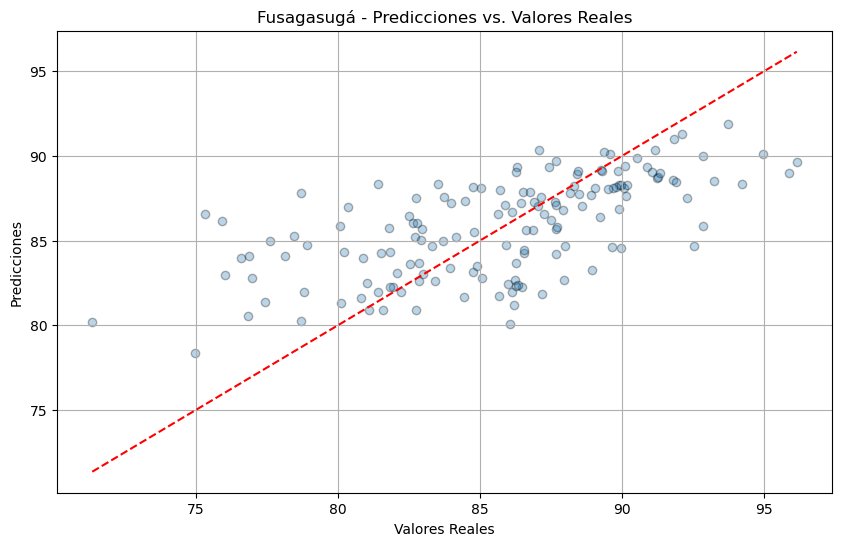

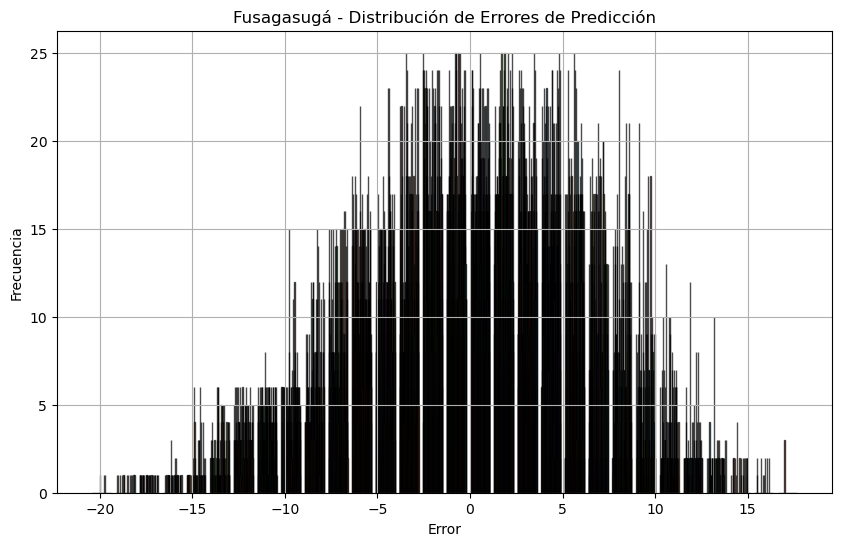

In [14]:
model_f2, score_f2, y_test_f2, y_pred_f2 = train_evaluate_svr(X_fusa, y_fusa)
print(f'Fusagasugá - SVR R^2 Score: {score_f:.2f}')
plot_results(y_test_f2, y_pred_f2, 'Fusagasugá')

#### Entrenar y evaluar modelo SVR para Girardot

C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Girardot - SVR R^2 Score: 0.37


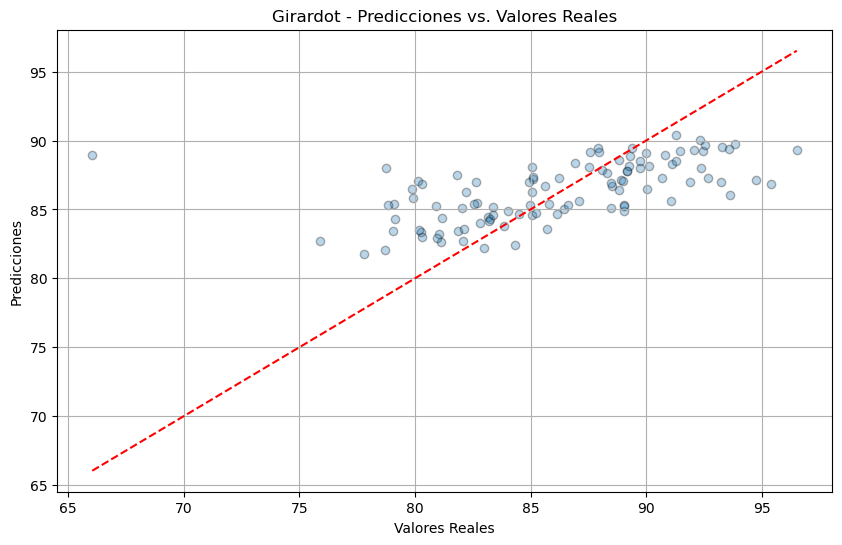

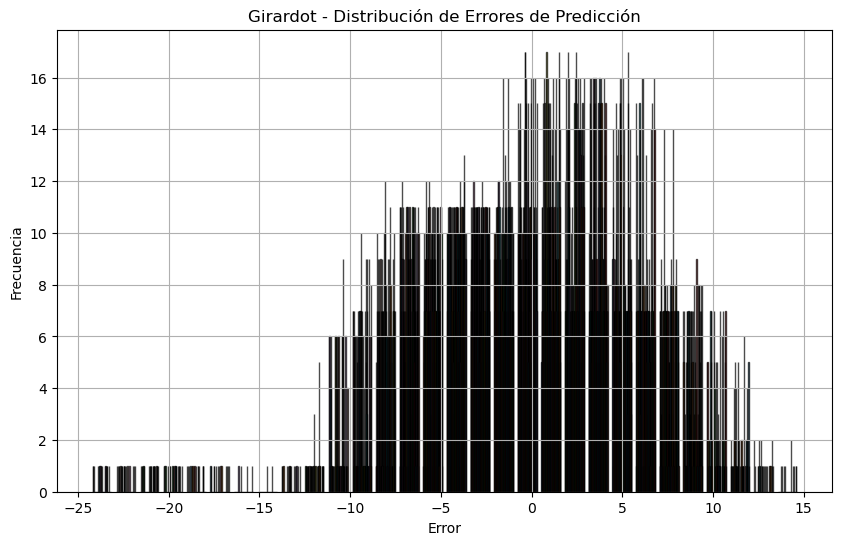

In [15]:
model_g2, score_g2, y_test_g2, y_pred_g2 = train_evaluate_svr(X_girardot, y_girardot)
print(f'Girardot - SVR R^2 Score: {score_g:.2f}')
plot_results(y_test_g2, y_pred_g2, 'Girardot')

## cambiar valor de notas a categoricos


In [16]:
def convert_to_categorical(df, column_name, bins, labels):
    
    df[column_name + '_Categorico'] = pd.cut(df[column_name], bins=bins, labels=labels, include_lowest=True)
    return df

In [17]:
intervalos = [0, 60, 75, 90, 100]  # Definir los intervalos para las categorías
clases = ['Muy Bajo', 'Bajo', 'Medio', 'Alto']  # Etiquetas para las categorías

calificaciones_grouped_fusa = convert_to_categorical(calificaciones_grouped_fusa, 'Calificacion_Ponderada', intervalos, clases)
calificaciones_grouped_girardot = convert_to_categorical(calificaciones_grouped_girardot, 'Calificacion_Ponderada', intervalos, clases)

In [18]:
calificaciones_grouped_fusa.head()

,Grado,Asignatura,Periodo,Año,Intensidad Horaria,Cognitiva,Procedimental,Actitudinal,Axiologica,Calificacion_Ponderada,Calificacion_Ponderada_Categorico
0,1,Aprendizaje Basado en Proyectos,I,2023,4.0,87.636364,87.181818,89.500000,92.545455,88.363636,Medio
1,1,Aprendizaje Basado en Proyectos,I,2024,2.0,88.200000,89.533333,90.266667,93.466667,89.540000,Medio
2,1,Aprendizaje Basado en Proyectos,II,2023,4.0,88.333333,88.444444,93.166667,93.722222,89.872222,Medio
3,1,Aprendizaje Basado en Proyectos,II,2024,2.0,91.933333,92.600000,90.733333,94.200000,92.120000,Alto
4,1,Aprendizaje Basado en Proyectos,III,2023,4.0,93.368421,93.421053,93.526316,92.421053,93.321053,Alto


In [19]:
calificaciones_grouped_girardot.head()

,Grado,Asignatura,Periodo,Año,Intensidad Horaria,Cognitiva,Procedimental,Actitudinal,Axiologica,Calificacion_Ponderada,Calificacion_Ponderada_Categorico
0,1,Aprendizaje Basado en Proyectos,I,2023,4.0,82.300000,83.400000,80.600000,85.800000,82.640000,Medio
1,1,Aprendizaje Basado en Proyectos,I,2024,2.0,89.687500,90.250000,86.125000,85.875000,88.762500,Medio
2,1,Aprendizaje Basado en Proyectos,II,2023,4.0,85.727273,85.818182,90.090909,88.818182,86.936364,Medio
3,1,Aprendizaje Basado en Proyectos,II,2024,2.0,92.277778,92.166667,88.944444,91.444444,91.494444,Alto
4,1,Aprendizaje Basado en Proyectos,III,2023,4.0,90.363636,91.272727,93.181818,94.000000,91.563636,Alto


In [20]:
X_fusa_c = calificaciones_grouped_fusa[['Grado', 'Asignatura', 'Intensidad Horaria','Periodo','Año']]
y_fusa_c = calificaciones_grouped_fusa[['Calificacion_Ponderada_Categorico']]

In [21]:
X_girardot_c = calificaciones_grouped_girardot[['Grado', 'Asignatura', 'Intensidad Horaria','Periodo','Año']]
y_girardot_c = calificaciones_grouped_girardot[['Calificacion_Ponderada_Categorico']]

### funciones de modelos

In [22]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_evaluate_random_forest(X, y):

    # Definir el preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Intensidad Horaria']),
            ('cat', OneHotEncoder(), ['Grado', 'Asignatura', 'Periodo', 'Año'])
        ])
    
    # Crear el pipeline para el modelo Random Forest
    model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestClassifier())])
    
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo Random Forest
    model_rf.fit(X_train, y_train)
    
    
    # Realizar predicciones
    y_pred = model_rf.predict(X_test)
    
    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'Random Forest - Accuracy: {accuracy:.2f}')
    print(f'Random Forest - Precision: {precision:.2f}')
    print(f'Random Forest - Recall: {recall:.2f}')
    print(f'Random Forest - F1 Score: {f1:.2f}')
    
    return model_rf, accuracy, precision, recall, f1, y_test, y_pred


In [30]:
from sklearn.svm import SVC

def train_evaluate_svc(X, y):

    # Definir el preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Intensidad Horaria']),
            ('cat', OneHotEncoder(), ['Grado', 'Asignatura', 'Periodo', 'Año'])
        ])
    
    # Crear el pipeline para el modelo Random Forest
    model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', SVC())])
    
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo Random Forest
    model_rf.fit(X_train, y_train)
    
    
    # Realizar predicciones
    y_pred = model_rf.predict(X_test)
    
    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'SVM - Accuracy: {accuracy:.2f}')
    print(f'SVM - Precision: {precision:.2f}')
    print(f'SVM - Recall: {recall:.2f}')
    print(f'SVM - F1 Score: {f1:.2f}')
    
    return model_rf, accuracy, precision, recall, f1, y_test, y_pred

In [24]:

import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,title_prefix):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{title_prefix} - Confusion Matrix')
    plt.show()

In [25]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_prob, title_prefix):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix} - ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

### ejecucion modelos de clasificacion para Fusa

C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest - Accuracy: 0.84
Random Forest - Precision: 0.84
Random Forest - Recall: 0.84
Random Forest - F1 Score: 0.83


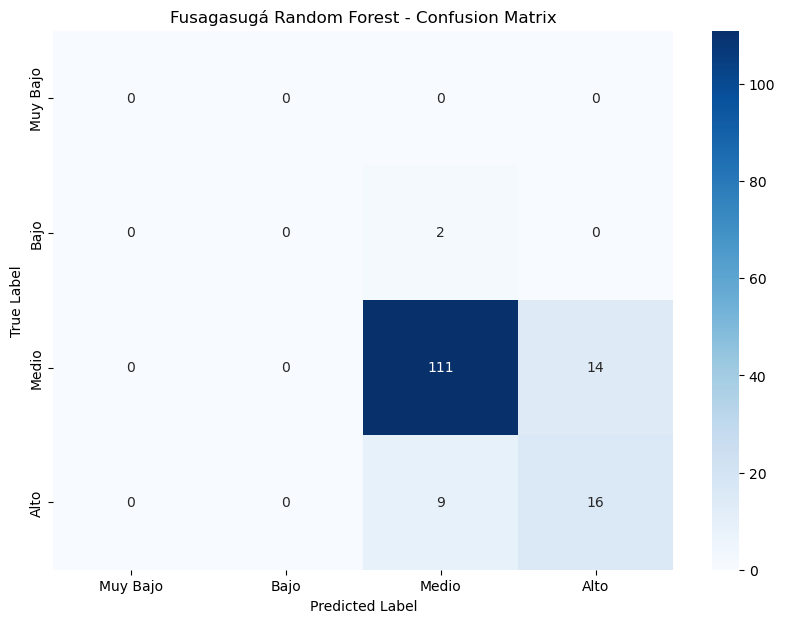

In [26]:
model_f3, accuracy_f3, precision_f3, recall_f3, f1_f3, y_test_f3, y_pred_f3 = train_evaluate_random_forest(X_fusa_c, y_fusa_c)
plot_confusion_matrix(y_test_f3, y_pred_f3, classes=clases, title_prefix='Fusagasugá Random Forest')

C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM - Accuracy: 0.83
SVM - Precision: 0.81
SVM - Recall: 0.83
SVM - F1 Score: 0.82


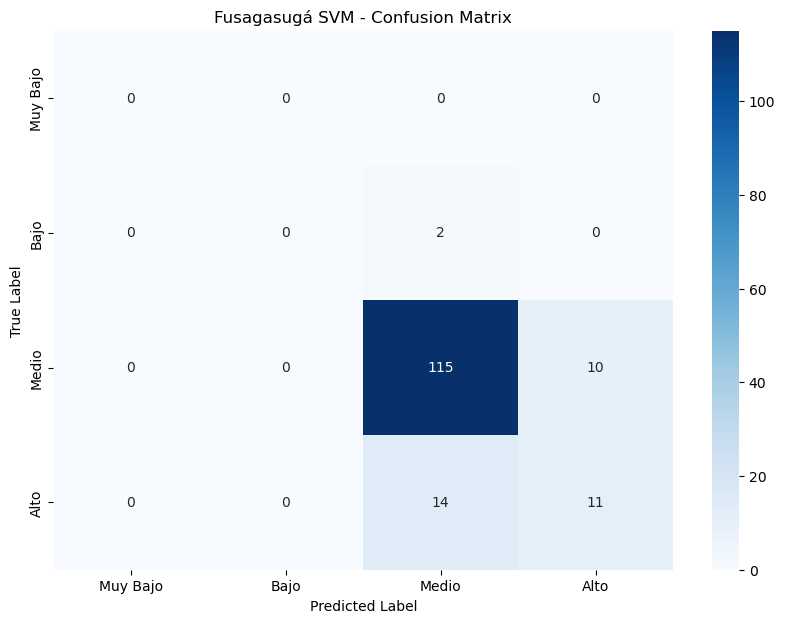

In [31]:
model_f4, accuracy_f4, precision_f4, recall_f4, f1_f4, y_test_f4, y_pred_f4 = train_evaluate_svc(X_fusa_c, y_fusa_c)
plot_confusion_matrix(y_test_f4, y_pred_f4, classes=clases, title_prefix='Fusagasugá SVM')

### ejecucion modelos de clasificacion para Girardot

C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest - Accuracy: 0.77
Random Forest - Precision: 0.74
Random Forest - Recall: 0.77
Random Forest - F1 Score: 0.75


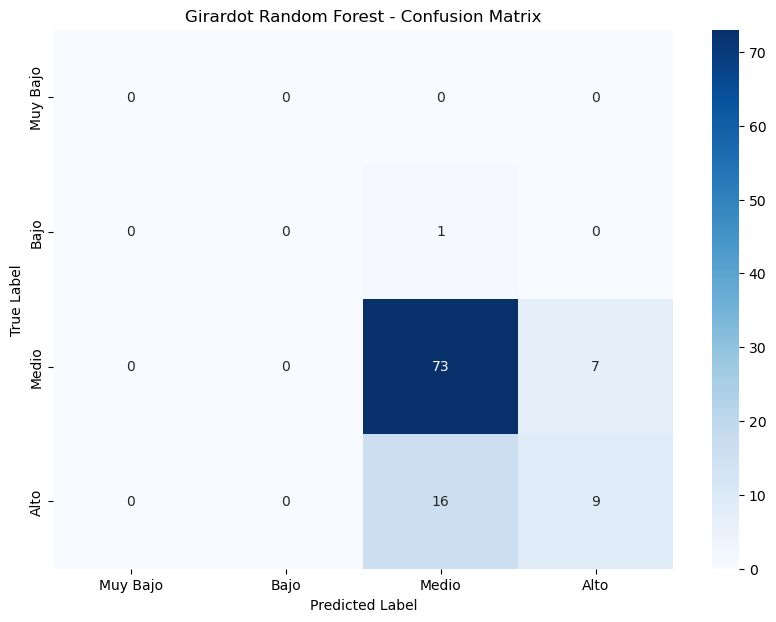

In [28]:
model_g3, accuracy_g3, precision_g3, recall_g3, f1_g3, y_test_g3, y_pred_g3 = train_evaluate_random_forest(X_girardot_c, y_girardot_c)
plot_confusion_matrix(y_test_g3, y_pred_g3, classes=clases, title_prefix='Girardot Random Forest')

C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM - Accuracy: 0.80
SVM - Precision: 0.79
SVM - Recall: 0.80
SVM - F1 Score: 0.76


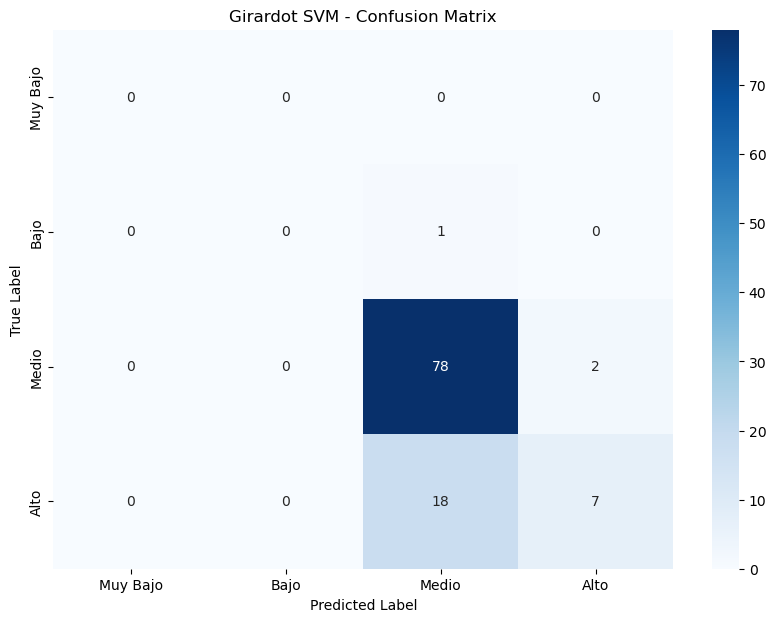

In [32]:
model_g4, accuracy_g4, precision_g4, recall_g4, f1_g4, y_test_g4, y_pred_g4 = train_evaluate_svc(X_girardot_c, y_girardot_c)
plot_confusion_matrix(y_test_g4, y_pred_g4, classes=clases, title_prefix='Girardot SVM')